# Why does sinabs-slayer model not work?

This notebook will show that for the wheel-motion classification toy task, the same model architecture can be trained with sinabs but training on sinabs-slayer fails. We will try to explore why this is the case.

The notebook's code is based on the script `binary_task.py`

SPOILER:
The problem was exploding gradients in the slayer model. Enabling an option to scale down the surrogate gradients resolved it.
The problem can be reproduced by setting `kwargs_spiking["scale_grads"]` to 1 (second code cell), which corresponds to the original value.

In [1]:
### --- Imports

import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

from slayerSNN import loss as SpikeLoss

from sinabs.from_torch import from_model
from sinabs.utils import get_activations
import sinabs.layers as sl

from data import InvertDirDataset
from binary_models import SlayerModel, ExodusModel

### --- Load events
raster = np.load("rotation_events.npy")
raster = raster.transpose(1,2,3,0)
print(raster.shape)

(2, 256, 256, 99)


In [35]:
# - Datset and loader
downsample = 10
num_ts = raster.shape[-1] // downsample
# Set sample_size and step_size such that each sample corresponds to all frames of one class
ds = InvertDirDataset(
    raster, sample_size=num_ts, step_size=num_ts, downsample=downsample
)
dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True)

# - Loss function
loss_func = torch.nn.CrossEntropyLoss()

# - Model parameters
kwargs_model = {
    "grad_width": 0.5,  # 0.5
    "grad_scale": 1,  # 0.02
    "thr": 1,
    "num_ts": num_ts,
}

# - Sinabs model
model_sinabs = ExodusModel(**kwargs_model).cuda()
model_sinabs.reset()
print("Sinabs model:")
print(model_sinabs)

model_slayer = SlayerModel(**kwargs_model).cuda()
print("Slayer model:")
print(model_slayer)

Sinabs model:
ExodusModel(
  (pool0): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (conv0): Conv2d(2, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (spk0): IAFSqueeze-module, backend: exodus
  (pool1): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (conv1): Conv2d(4, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (spk1): IAFSqueeze-module, backend: exodus
  (pool2): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (linear): Linear(in_features=128, out_features=2, bias=False)
)
Slayer model:
SlayerModel(
  (slayer): SlayerLayer()
  (pool0): _poolLayer(1, 1, kernel_size=(4, 4, 1), stride=(4, 4, 1), bias=False)
  (conv0): _convLayer(2, 4, kernel_size=(7, 7, 1), stride=(1, 1, 1), padding=(3, 3, 0), bias=False)
  (pool1): _poolLayer(1, 1, kernel_size=(4, 4, 1), stride=(4, 4, 1), bias=False)
  (conv1): _convLayer(4, 8, kernel_size=(7, 7, 1), stride=(1, 1, 1), padding=(3, 3, 0), bias=False)
  (pool2): _poolLayer(1, 1, kernel_size=(4, 4, 1), stride

In [36]:
# - Transfer weights from sinabs to slayer model to ensure same initial conditions
model_slayer.conv0.weight.data = model_sinabs.conv0.weight.data.unsqueeze(-1).clone()
model_slayer.conv1.weight.data = model_sinabs.conv1.weight.data.unsqueeze(-1).clone()
model_slayer.linear.weight.data = model_sinabs.linear.weight.data.clone().reshape(2, 8, 4, 4, 1)

In [37]:
print(model_sinabs.linear.weight.shape)
print(model_slayer.linear.weight.shape)

torch.Size([2, 128])
torch.Size([2, 8, 4, 4, 1])


In [38]:
print(ds[0][0].shape)
print(len(ds))

torch.Size([2, 256, 256, 9])
2


Now the two models should produce the same output for a given input. Let's make sure this is the case

In [39]:
# - Compare outputs before training
outputs_slayer = []
outputs_sinabs = []

with torch.no_grad():
    # Load input from dataset to avoid shuffling.
    for inp, *__ in ds:
        # Add batch dimension
        inp = inp.unsqueeze(0).cuda()
        outputs_slayer.append(model_slayer(inp))
        outputs_sinabs.append(model_sinabs(inp))
        model_sinabs.reset()

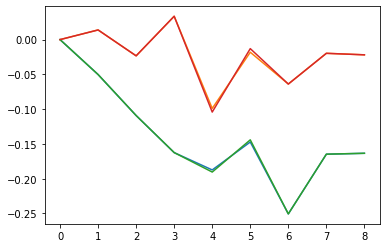

In [40]:
os = outputs_slayer[1].squeeze(0).cpu().detach()
oe = outputs_sinabs[1].squeeze(0).cpu().detach()
plt.plot(oe.t())
plt.plot(os.t())

Outputs seem very similar.

In [41]:
# - Set up training
loss_func = torch.nn.CrossEntropyLoss()
optim_sin = torch.optim.SGD(model_sinabs.parameters(), lr=1e-3)
optim_slr = torch.optim.SGD(model_slayer.parameters(), lr=1e-3)

# - Do a single batch

dl_iter = iter(dl)
inp, tgt, onehot = next(dl_iter)
print("Target:", tgt)
inp = inp.cuda()

# Sinabs
out_sin = model_sinabs(inp).sum(-1).cpu()
optim_sin.zero_grad()
loss_sin = loss_func(out_sin, tgt)
loss_sin.backward()
grads_sin = [p.grad for p in model_sinabs.parameters()]
model_sinabs.reset()

# Slayer
out_slr = model_slayer(inp).sum(-1).cpu()
optim_slr.zero_grad()
loss_slr = loss_func(out_slr, tgt)
loss_slr.backward()
grads_slr = [p.grad.squeeze(-1) for p in model_slayer.parameters() if p.grad is not None]

print(f"Losses - Sinabs: {loss_sin.item()}, Slayer: {loss_slr.item()}")


Target: tensor([0])
Losses - Sinabs: 1.1627702713012695, Slayer: 1.1579868793487549


In [42]:
print([torch.max(g) for g in grads_sin])
print([torch.max(g) for g in grads_slr])

print([torch.std(g) for g in grads_sin])
print([torch.std(g) for g in grads_slr])

[tensor(1.5093, device='cuda:0'), tensor(1.6104, device='cuda:0'), tensor(2.7500, device='cuda:0')]
[tensor(16.8924, device='cuda:0'), tensor(6.0056, device='cuda:0'), tensor(2.7435, device='cuda:0')]
[tensor(0.4951, device='cuda:0'), tensor(0.4814, device='cuda:0'), tensor(0.8683, device='cuda:0')]
[tensor(4.2666, device='cuda:0'), tensor(1.6520, device='cuda:0'), tensor(0.8662, device='cuda:0')]


It turns out that with the default scaling (`kwargs_spiking["scale_grads"] = 1.0`), the gradients in the slayer model explode. After trying a few values, setting the scale to 0.02 seems to give reasonable gradients.
Let's train both models to see, whether everything works now.

In [43]:
# - Training loop

mistakes_sin = []
mistakes_slr = []

for ep in range(40):
    print(f"Epoch {ep} ------------------------------------------------------")
    for inp, tgt, __ in dl:
        inp = inp.cuda()       
        
        # Sinabs
        out_sin = model_sinabs(inp).sum(-1).cpu()
        __, predict_sin = torch.max(out_sin, 1)
        optim_sin.zero_grad()
        loss_sin = loss_func(out_sin, tgt)
        loss_sin.backward()
        optim_sin.step()
        model_sinabs.reset()
        sin_right = tgt.item() == predict_sin.item()
        mistakes_sin.append(int(not sin_right))

        # Slayer
        out_slr = model_slayer(inp).sum(-1).cpu()
        __, predict_slr = torch.max(out_slr, 1)
        optim_slr.zero_grad()
        loss_slr = loss_func(out_slr, tgt)
        loss_slr.backward()
        optim_slr.step()        
        slr_right = tgt.item() == predict_slr.item()
        mistakes_slr.append(int(not slr_right))
        
        # Print statement
        print(f"Target: {tgt.item()}")
        print(f"Prediction sinabs: {predict_sin.item()} ({'correct' if sin_right else 'wrong'})")
        print(f"Prediction slayer: {predict_slr.item()} ({'correct' if slr_right else 'wrong'})")
                
    # print(ep, sum(tl[-5:]), end="\r")
    print(f"Total mistakes sinabs: {sum(mistakes_sin)}, slayer: {sum(mistakes_slr)} -----------------------")

Epoch 0 ------------------------------------------------------
Target: 0
Prediction sinabs: 1 (wrong)
Prediction slayer: 1 (wrong)
Target: 1
Prediction sinabs: 1 (correct)
Prediction slayer: 0 (wrong)
Total mistakes sinabs: 1, slayer: 2 -----------------------
Epoch 1 ------------------------------------------------------
Target: 1
Prediction sinabs: 1 (correct)
Prediction slayer: 1 (correct)
Target: 0
Prediction sinabs: 1 (wrong)
Prediction slayer: 1 (wrong)
Total mistakes sinabs: 2, slayer: 3 -----------------------
Epoch 2 ------------------------------------------------------
Target: 0
Prediction sinabs: 1 (wrong)
Prediction slayer: 0 (correct)
Target: 1
Prediction sinabs: 1 (correct)
Prediction slayer: 1 (correct)
Total mistakes sinabs: 3, slayer: 3 -----------------------
Epoch 3 ------------------------------------------------------
Target: 0
Prediction sinabs: 0 (correct)
Prediction slayer: 0 (correct)
Target: 1
Prediction sinabs: 1 (correct)
Prediction slayer: 1 (correct)
Tota

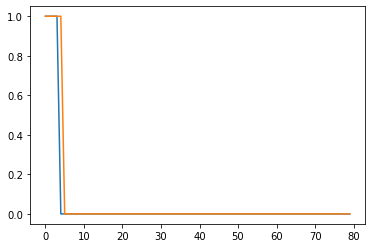

In [9]:
plt.plot(mistakes_sin)
plt.plot(mistakes_slr)

Both models don't make mistakes anymore after a few epochs.

The same can be done with the moving checkerboard data instead of a rotating wheel (see `simple_task.py`). Here, the gradients for slayer need different scaling. It seems like bptt in sinabs is more robust here.